# Notebook 03: Feature Engineering

## Mục Tiêu
- Tạo features từ time series data cho forecasting models
- Temporal features (hour, day_of_week, cyclical encoding)
- Lag features và rolling statistics
- Chuẩn bị data cho supervised learning

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))

from src.features.feature_engineering import TimeSeriesFeatureEngineer
from src.data.preprocessor import load_timeseries, split_train_test

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', 50)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load time series data (15-minute granularity)
df_15min = load_timeseries('../data/processed/timeseries_15min.parquet')

print(f"Data shape: {df_15min.shape}")
print(f"Date range: {df_15min.index.min()} to {df_15min.index.max()}")
print(f"\nColumns: {df_15min.columns.tolist()}")
df_15min.head()

Data shape: (5952, 11)
Date range: 1995-07-01 00:00:00 to 1995-08-31 23:45:00

Columns: ['request_count', 'bytes_total', 'bytes_mean', 'bytes_std', 'success_count', 'error_count', 'server_error_count', 'unique_hosts', 'error_rate', 'avg_request_size', 'is_storm_period']


,request_count,bytes_total,bytes_mean,bytes_std,success_count,error_count,server_error_count,unique_hosts,error_rate,avg_request_size,is_storm_period
1995-07-01 00:00:00,810,16430564,20284.646914,68996.794294,805,5,0,115,0.006173,20284.646914,0
1995-07-01 00:15:00,945,18046060,19096.359788,65257.390589,940,5,0,134,0.005291,19096.359788,0
1995-07-01 00:30:00,1006,22420824,22287.101392,59709.199929,1002,4,0,130,0.003976,22287.101392,0
1995-07-01 00:45:00,804,24088038,29960.246269,93142.239622,794,10,0,130,0.012438,29960.246269,0
1995-07-01 01:00:00,750,17178646,22904.861333,87973.213741,748,2,0,117,0.002667,22904.861333,0


In [3]:
# Loại bỏ storm period cho training
df_clean = df_15min[df_15min['is_storm_period'] == 0].copy()
print(f"Clean data: {len(df_clean)} records (removed {len(df_15min) - len(df_clean)} storm records)")

Clean data: 5801 records (removed 151 storm records)


## 2. Feature Engineering với TimeSeriesFeatureEngineer

In [4]:
# Khởi tạo Feature Engineer
fe = TimeSeriesFeatureEngineer(df_clean)

# Tạo tất cả features
df_features = fe.create_all_features(
    target_col='request_count',
    granularity='15min'
)

print(f"Feature DataFrame shape: {df_features.shape}")
print(f"\nNumber of features created: {len(df_features.columns)}")

Creating features for 'request_count'...
  Lags: [1, 2, 4, 8, 96]
  Windows: [4, 8, 96]
  Diff periods: [1, 4, 96]
  EWM spans: [4, 96]
  + Temporal features added
  + Lag features added
  + Rolling features added
  + Diff features added
  + EWM features added

Total features: 47
NaN rows (due to lags): 528
Feature DataFrame shape: (5801, 47)

Number of features created: 47


In [5]:
# Xem tất cả features
print("All features:")
for i, col in enumerate(df_features.columns):
    print(f"  {i+1}. {col}")

All features:
  1. request_count
  2. bytes_total
  3. bytes_mean
  4. bytes_std
  5. success_count
  6. error_count
  7. server_error_count
  8. unique_hosts
  9. error_rate
  10. avg_request_size
  11. is_storm_period
  12. hour
  13. day_of_week
  14. day_of_month
  15. week_of_year
  16. month
  17. is_weekend
  18. is_business_hour
  19. hour_sin
  20. hour_cos
  21. dow_sin
  22. dow_cos
  23. request_count_lag_1
  24. request_count_lag_2
  25. request_count_lag_4
  26. request_count_lag_8
  27. request_count_lag_96
  28. request_count_rolling_mean_4
  29. request_count_rolling_std_4
  30. request_count_rolling_max_4
  31. request_count_rolling_min_4
  32. request_count_rolling_mean_8
  33. request_count_rolling_std_8
  34. request_count_rolling_max_8
  35. request_count_rolling_min_8
  36. request_count_rolling_mean_96
  37. request_count_rolling_std_96
  38. request_count_rolling_max_96
  39. request_count_rolling_min_96
  40. request_count_diff_1
  41. request_count_pct_change

## 3. Chi Tiết Các Loại Features

### 3.1 Temporal Features

In [6]:
# Temporal features
temporal_cols = ['hour', 'day_of_week', 'day_of_month', 'is_weekend', 'is_business_hour',
                 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

print("Temporal Features:")
df_features[temporal_cols].head(10)

Temporal Features:


,hour,day_of_week,day_of_month,is_weekend,is_business_hour,hour_sin,hour_cos,dow_sin,dow_cos
1995-07-01 00:00:00,0,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521
1995-07-01 00:15:00,0,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521
1995-07-01 00:30:00,0,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521
1995-07-01 00:45:00,0,5,1,1,0,0.000000,1.000000,-0.974928,-0.222521
1995-07-01 01:00:00,1,5,1,1,0,0.258819,0.965926,-0.974928,-0.222521
1995-07-01 01:15:00,1,5,1,1,0,0.258819,0.965926,-0.974928,-0.222521
1995-07-01 01:30:00,1,5,1,1,0,0.258819,0.965926,-0.974928,-0.222521
1995-07-01 01:45:00,1,5,1,1,0,0.258819,0.965926,-0.974928,-0.222521
1995-07-01 02:00:00,2,5,1,1,0,0.500000,0.866025,-0.974928,-0.222521
1995-07-01 02:15:00,2,5,1,1,0,0.500000,0.866025,-0.974928,-0.222521


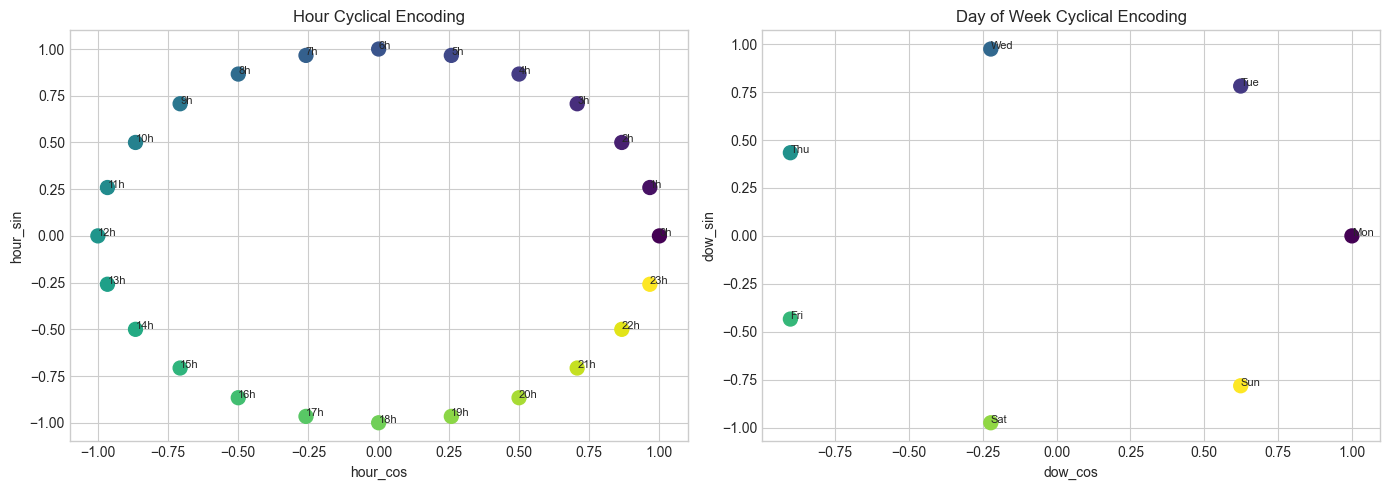

In [7]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hour cyclical
sample = df_features[['hour', 'hour_sin', 'hour_cos']].drop_duplicates().sort_values('hour')
axes[0].scatter(sample['hour_cos'], sample['hour_sin'], c=sample['hour'], cmap='viridis', s=100)
axes[0].set_xlabel('hour_cos')
axes[0].set_ylabel('hour_sin')
axes[0].set_title('Hour Cyclical Encoding')
for _, row in sample.iterrows():
    axes[0].annotate(f"{int(row['hour'])}h", (row['hour_cos'], row['hour_sin']), fontsize=8)

# Day of week cyclical
sample_dow = df_features[['day_of_week', 'dow_sin', 'dow_cos']].drop_duplicates().sort_values('day_of_week')
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].scatter(sample_dow['dow_cos'], sample_dow['dow_sin'], c=sample_dow['day_of_week'], cmap='viridis', s=100)
axes[1].set_xlabel('dow_cos')
axes[1].set_ylabel('dow_sin')
axes[1].set_title('Day of Week Cyclical Encoding')
for _, row in sample_dow.iterrows():
    axes[1].annotate(days[int(row['day_of_week'])], (row['dow_cos'], row['dow_sin']), fontsize=8)

plt.tight_layout()
plt.savefig('../reports/figures/cyclical_encoding.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Lag Features

In [8]:
# Lag features
lag_cols = [col for col in df_features.columns if '_lag_' in col]
print(f"Lag features ({len(lag_cols)}): {lag_cols}")

# Sample data
df_features[['request_count'] + lag_cols].head(10)

Lag features (5): ['request_count_lag_1', 'request_count_lag_2', 'request_count_lag_4', 'request_count_lag_8', 'request_count_lag_96']


,request_count,request_count_lag_1,request_count_lag_2,request_count_lag_4,request_count_lag_8,request_count_lag_96
1995-07-01 00:00:00,810,NaN,NaN,NaN,NaN,NaN
1995-07-01 00:15:00,945,810.0,NaN,NaN,NaN,NaN
1995-07-01 00:30:00,1006,945.0,810.0,NaN,NaN,NaN
1995-07-01 00:45:00,804,1006.0,945.0,NaN,NaN,NaN
1995-07-01 01:00:00,750,804.0,1006.0,810.0,NaN,NaN
1995-07-01 01:15:00,679,750.0,804.0,945.0,NaN,NaN
1995-07-01 01:30:00,833,679.0,750.0,1006.0,NaN,NaN
1995-07-01 01:45:00,742,833.0,679.0,804.0,NaN,NaN
1995-07-01 02:00:00,697,742.0,833.0,750.0,810.0,NaN
1995-07-01 02:15:00,538,697.0,742.0,679.0,945.0,NaN


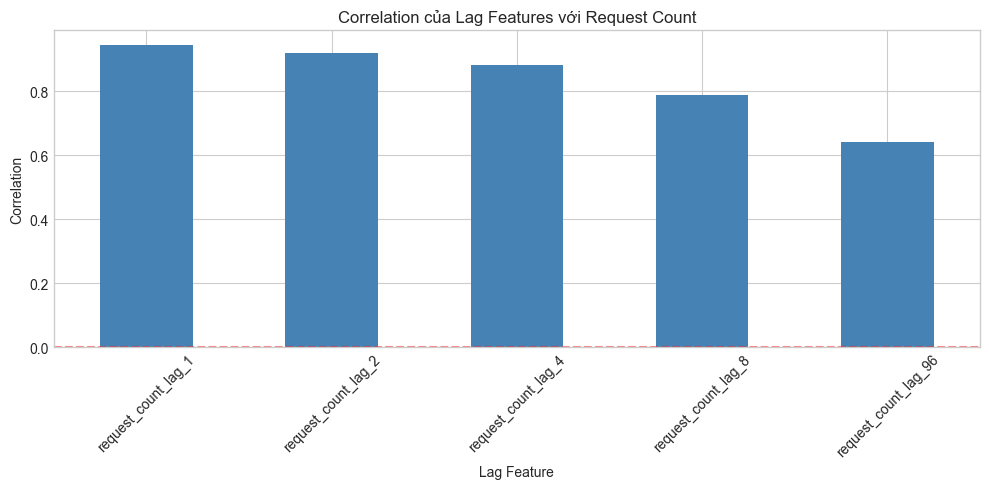


Lag Correlations:
request_count_lag_1     0.943606
request_count_lag_2     0.920128
request_count_lag_4     0.881895
request_count_lag_8     0.787182
request_count_lag_96    0.642985
Name: request_count, dtype: float64


In [9]:
# Correlation của lag features với target
if len(lag_cols) > 0:
    lag_corr = df_features[['request_count'] + lag_cols].corr()['request_count'].drop('request_count')
    
    plt.figure(figsize=(10, 5))
    lag_corr.plot(kind='bar', color='steelblue')
    plt.title('Correlation của Lag Features với Request Count')
    plt.xlabel('Lag Feature')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('../reports/figures/lag_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nLag Correlations:")
    print(lag_corr.sort_values(ascending=False))
else:
    print("No lag features found!")

### 3.3 Rolling Statistics

In [10]:
# Rolling features
rolling_cols = [col for col in df_features.columns if '_rolling_' in col]
print(f"Rolling features ({len(rolling_cols)}): {rolling_cols}")

Rolling features (12): ['request_count_rolling_mean_4', 'request_count_rolling_std_4', 'request_count_rolling_max_4', 'request_count_rolling_min_4', 'request_count_rolling_mean_8', 'request_count_rolling_std_8', 'request_count_rolling_max_8', 'request_count_rolling_min_8', 'request_count_rolling_mean_96', 'request_count_rolling_std_96', 'request_count_rolling_max_96', 'request_count_rolling_min_96']


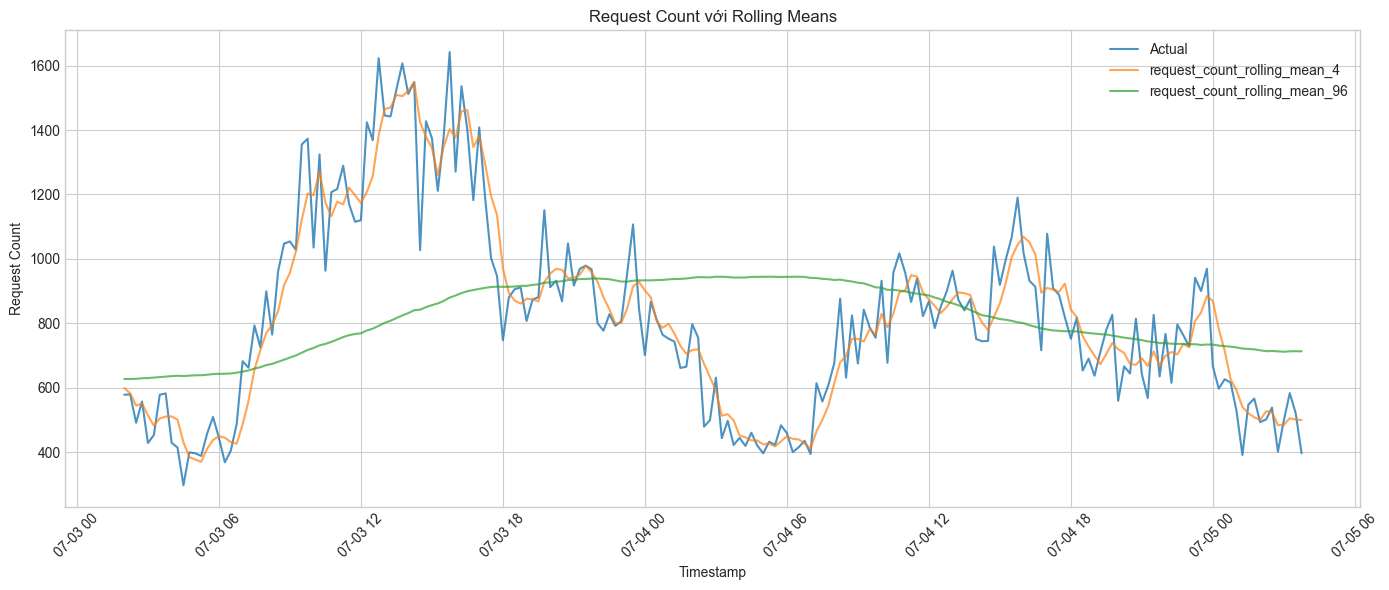

In [11]:
# Visualize rolling statistics
sample_data = df_features.iloc[200:400].copy()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(sample_data.index, sample_data['request_count'], label='Actual', alpha=0.8)

# Rolling means - check with correct column names
rolling_mean_cols = [col for col in sample_data.columns if '_rolling_mean_' in col]
if len(rolling_mean_cols) >= 1:
    ax.plot(sample_data.index, sample_data[rolling_mean_cols[0]], label=f'{rolling_mean_cols[0]}', alpha=0.7)
if len(rolling_mean_cols) >= 2:
    ax.plot(sample_data.index, sample_data[rolling_mean_cols[-1]], label=f'{rolling_mean_cols[-1]}', alpha=0.7)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Request Count với Rolling Means')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/rolling_features.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Derived Features (Diff, Pct Change, EWM)

In [12]:
# Derived features
derived_cols = [col for col in df_features.columns if '_diff_' in col or '_pct_change_' in col or '_ewm_' in col]
print(f"Derived features ({len(derived_cols)}): {derived_cols}")

Derived features (8): ['request_count_diff_1', 'request_count_pct_change_1', 'request_count_diff_4', 'request_count_pct_change_4', 'request_count_diff_96', 'request_count_pct_change_96', 'request_count_ewm_4', 'request_count_ewm_96']


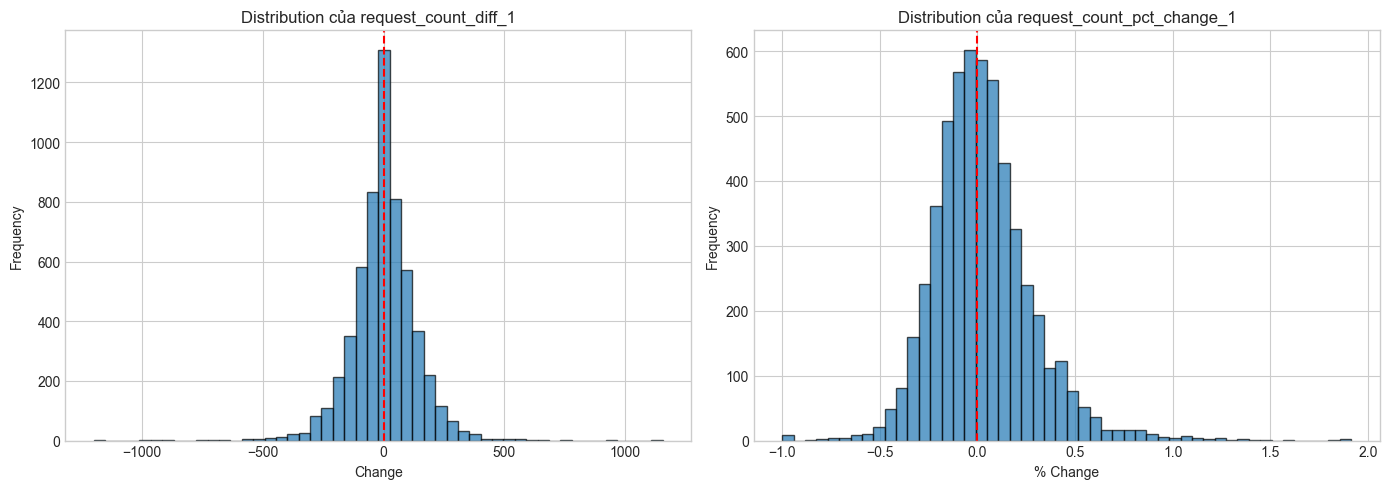

In [13]:
# Distribution của diff features
diff_col = [col for col in df_features.columns if '_diff_1' in col]
pct_col = [col for col in df_features.columns if '_pct_change_1' in col]

if len(diff_col) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Diff distribution
    axes[0].hist(df_features[diff_col[0]].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0, color='red', linestyle='--')
    axes[0].set_title(f'Distribution của {diff_col[0]}')
    axes[0].set_xlabel('Change')
    axes[0].set_ylabel('Frequency')
    
    # Pct change distribution
    if len(pct_col) > 0:
        pct_data = df_features[pct_col[0]].dropna()
        pct_data = pct_data[(pct_data > -2) & (pct_data < 2)]  # Filter outliers
        axes[1].hist(pct_data, bins=50, edgecolor='black', alpha=0.7)
        axes[1].axvline(x=0, color='red', linestyle='--')
        axes[1].set_title(f'Distribution của {pct_col[0]}')
        axes[1].set_xlabel('% Change')
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/derived_features.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No diff features found!")

## 4. Feature Selection

In [14]:
# Lấy danh sách feature columns
feature_cols = fe.get_feature_columns(df_features)
print(f"Total feature columns: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Total feature columns: 36

Features: ['hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'is_weekend', 'is_business_hour', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'request_count_lag_1', 'request_count_lag_2', 'request_count_lag_4', 'request_count_lag_8', 'request_count_lag_96', 'request_count_rolling_mean_4', 'request_count_rolling_std_4', 'request_count_rolling_max_4', 'request_count_rolling_min_4', 'request_count_rolling_mean_8', 'request_count_rolling_std_8', 'request_count_rolling_max_8', 'request_count_rolling_min_8', 'request_count_rolling_mean_96', 'request_count_rolling_std_96', 'request_count_rolling_max_96', 'request_count_rolling_min_96', 'request_count_diff_1', 'request_count_pct_change_1', 'request_count_diff_4', 'request_count_pct_change_4', 'request_count_diff_96', 'request_count_pct_change_96', 'request_count_ewm_4', 'request_count_ewm_96']


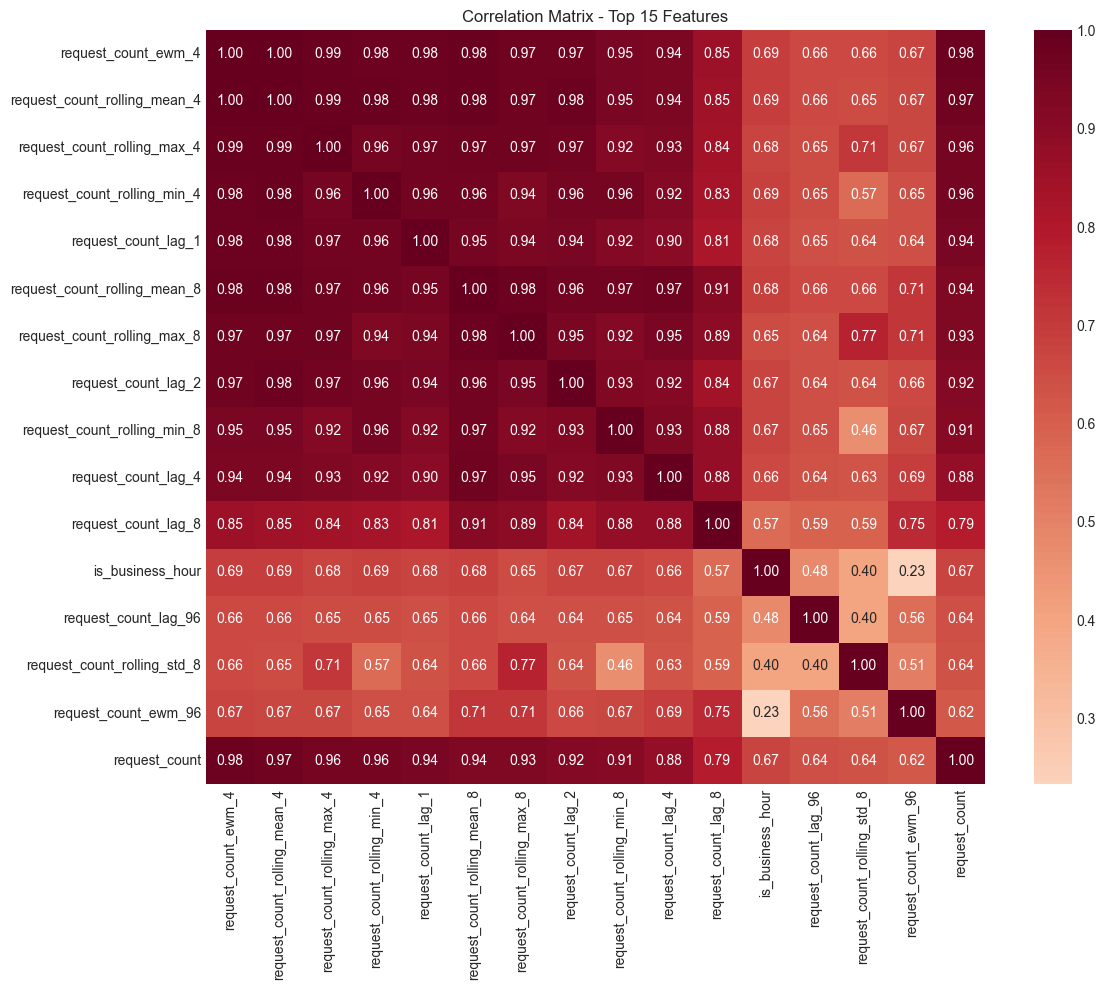

In [15]:
# Correlation matrix cho top features
# Chọn features có correlation cao với target
corr_with_target = df_features[feature_cols + ['request_count']].corr()['request_count'].drop('request_count')
top_features = corr_with_target.abs().nlargest(15).index.tolist()

# Correlation heatmap
corr_matrix = df_features[top_features + ['request_count']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Correlation Matrix - Top 15 Features')
plt.tight_layout()
plt.savefig('../reports/figures/feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Top features by correlation
print("Top 20 Features by Correlation với Target:")
print("="*50)
for i, (feat, corr) in enumerate(corr_with_target.abs().nlargest(20).items()):
    actual_corr = corr_with_target[feat]
    print(f"{i+1:2d}. {feat:30s}: {actual_corr:+.4f}")

Top 20 Features by Correlation với Target:
 1. request_count_ewm_4           : +0.9799
 2. request_count_rolling_mean_4  : +0.9676
 3. request_count_rolling_max_4   : +0.9591
 4. request_count_rolling_min_4   : +0.9550
 5. request_count_lag_1           : +0.9436
 6. request_count_rolling_mean_8  : +0.9362
 7. request_count_rolling_max_8   : +0.9312
 8. request_count_lag_2           : +0.9201
 9. request_count_rolling_min_8   : +0.9054
10. request_count_lag_4           : +0.8819
11. request_count_lag_8           : +0.7872
12. is_business_hour              : +0.6734
13. request_count_lag_96          : +0.6430
14. request_count_rolling_std_8   : +0.6394
15. request_count_ewm_96          : +0.6240
16. request_count_rolling_std_4   : +0.5728
17. request_count_rolling_mean_96 : +0.5520
18. request_count_rolling_max_96  : +0.5082
19. request_count_rolling_min_96  : +0.4838
20. hour_cos                      : -0.4600


## 5. Prepare Supervised Learning Data

In [17]:
# Chuẩn bị data cho supervised learning
X, y = fe.prepare_supervised(
    df_features,
    target_col='request_count',
    feature_cols=feature_cols,
    forecast_horizon=1  # Dự đoán 1 step ahead
)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFirst few rows of X:")
X.head()

X shape: (5274, 36)
y shape: (5274,)

First few rows of X:


,hour,day_of_week,day_of_month,week_of_year,month,is_weekend,is_business_hour,hour_sin,hour_cos,dow_sin,dow_cos,request_count_lag_1,request_count_lag_2,request_count_lag_4,request_count_lag_8,request_count_lag_96,request_count_rolling_mean_4,request_count_rolling_std_4,request_count_rolling_max_4,request_count_rolling_min_4,request_count_rolling_mean_8,request_count_rolling_std_8,request_count_rolling_max_8,request_count_rolling_min_8,request_count_rolling_mean_96,request_count_rolling_std_96,request_count_rolling_max_96,request_count_rolling_min_96,request_count_diff_1,request_count_pct_change_1,request_count_diff_4,request_count_pct_change_4,request_count_diff_96,request_count_pct_change_96,request_count_ewm_4,request_count_ewm_96
1995-07-02 00:00:00,0,6,2,26,7,1,0,0.000000,1.000000,-0.781831,0.62349,483.0,785.0,684.0,879.0,810.0,696.75,183.844817,901.0,483.0,733.750,133.668834,901.0,483.0,672.104167,210.024233,1030.0,209.0,135.0,0.279503,-66.0,-0.096491,-192.0,-0.237037,652.508549,736.438940
1995-07-02 00:15:00,0,6,2,26,7,1,0,0.000000,1.000000,-0.781831,0.62349,618.0,483.0,901.0,827.0,945.0,658.75,137.395718,785.0,483.0,724.000,128.645693,901.0,483.0,670.062500,208.288960,1030.0,209.0,131.0,0.211974,-152.0,-0.168701,-196.0,-0.207407,691.105130,736.697931
1995-07-02 00:30:00,0,6,2,26,7,1,0,0.000000,1.000000,-0.781831,0.62349,749.0,618.0,785.0,758.0,1006.0,662.25,141.791807,799.0,483.0,729.125,130.989026,901.0,483.0,667.906250,205.831616,1030.0,209.0,50.0,0.066756,14.0,0.017834,-207.0,-0.205765,734.263078,737.982510
1995-07-02 00:45:00,0,6,2,26,7,1,0,0.000000,1.000000,-0.781831,0.62349,799.0,749.0,483.0,814.0,804.0,714.50,77.779603,799.0,618.0,713.875,126.728548,901.0,483.0,666.739583,205.369000,1030.0,209.0,-107.0,-0.133917,209.0,0.432712,-112.0,-0.139303,717.357847,737.034417
1995-07-02 01:00:00,1,6,2,26,7,1,0,0.258819,0.965926,-0.781831,0.62349,692.0,799.0,618.0,684.0,750.0,694.50,113.120879,799.0,538.0,695.625,141.318220,901.0,483.0,664.531250,205.603960,1030.0,209.0,-154.0,-0.222543,-80.0,-0.129450,-212.0,-0.282667,645.614708,732.930615


In [18]:
# Train/Test split
test_start = '1995-08-23'
train_mask = X.index < test_start

X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train set: {len(X_train)} samples ({X_train.index.min()} to {X_train.index.max()})")
print(f"Test set: {len(X_test)} samples ({X_test.index.min()} to {X_test.index.max()})")

Train set: 4411 samples (1995-07-02 00:00:00 to 1995-08-22 23:45:00)
Test set: 863 samples (1995-08-23 00:00:00 to 1995-08-31 23:30:00)


In [19]:
# Check for missing values
missing = X.isnull().sum()
missing_cols = missing[missing > 0]

if len(missing_cols) > 0:
    print("Columns with missing values:")
    print(missing_cols)
else:
    print("No missing values in feature columns!")

No missing values in feature columns!


## 6. Save Processed Data

In [20]:
# Save feature-engineered data
df_features.to_parquet('../data/processed/features_15min.parquet')
print("Saved: features_15min.parquet")

# Save train/test splits
X_train.to_parquet('../data/processed/X_train_15min.parquet')
X_test.to_parquet('../data/processed/X_test_15min.parquet')
y_train.to_frame().to_parquet('../data/processed/y_train_15min.parquet')
y_test.to_frame().to_parquet('../data/processed/y_test_15min.parquet')

print("\nTrain/Test data saved!")

Saved: features_15min.parquet

Train/Test data saved!


## 7. Summary

In [21]:
print("="*60)
print("            FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nGranularity: 15 minutes")
print(f"Total records: {len(df_features)}")
print(f"\nFeatures created: {len(feature_cols)}")
print(f"  - Temporal: hour, day_of_week, is_weekend, cyclical encoding")
print(f"  - Lag: {[c for c in feature_cols if c.startswith('lag_')]}")
print(f"  - Rolling: mean, std, max, min")
print(f"  - Derived: diff, pct_change, ewm")
print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nTop 5 Features by Correlation:")
for feat, corr in corr_with_target.abs().nlargest(5).items():
    print(f"  - {feat}: {corr_with_target[feat]:+.4f}")
print("="*60)

            FEATURE ENGINEERING SUMMARY

Granularity: 15 minutes
Total records: 5801

Features created: 36
  - Temporal: hour, day_of_week, is_weekend, cyclical encoding
  - Lag: []
  - Rolling: mean, std, max, min
  - Derived: diff, pct_change, ewm

Train samples: 4411
Test samples: 863

Top 5 Features by Correlation:
  - request_count_ewm_4: +0.9799
  - request_count_rolling_mean_4: +0.9676
  - request_count_rolling_max_4: +0.9591
  - request_count_rolling_min_4: +0.9550
  - request_count_lag_1: +0.9436
